### 19. Proces M/M/1 - zależność od tempa obsługi zdarzeń
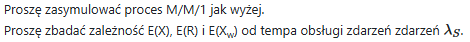

In [1]:
import numpy as np
from collections import deque